<img src="img/decisionmaking.png" width=400>

# ELEC-E7851 - Computational User Interface Design
# Lecture 10 - Modeling decision making

**Aurélien Nioche**

Aalto University

## Objectives

1. Learn by a basic example the elementary rules of cognitive modeling
2. ...what includes learn how to make model comparisons
3. ...what includes learn how to implement it

## Course Overview

<img src="img/design.png" width=30, align="left">&nbsp;&nbsp;&nbsp;&nbsp;1. **Task Model and Cognitive Models**

1.1 Task definition

1.2 Models definition


<img src="img/simulation.jpg" width=50, align="left">&nbsp;2. **First Simulations**

2.1 Represent the effect of the free parameters on behavior

2.2 Simulate a single agent

2.3 Analyse latent variables

2.4 Simulate a population of homogeneous agents


<img src="img/optimization.jpeg" width=50, align="left">&nbsp;3. **Parameter Recovery**

3.1 Define your likelihood function

3.2 Choose a way to search for the best parameters

3.3 Try with a single agent

3.4 Explore the behavior of the likelihood function over parameter space

3.5 Try with a homogeneous population

3.6 Systematize the approach

<img src="img/competition.png" width=50, align="left">&nbsp;4. **Model Recovery**

4.1 Choose a metric
    
4.2 Try with a single subject

4.3 Systematize the approach

<img src="img/experiment.jpg" width=30, align="left">&nbsp;&nbsp;&nbsp;&nbsp;5. **Fake experiment**

## Preambule

Import the modules

In [1]:
import numpy as np
import scipy.optimize
import scipy.stats
from itertools import product
from tqdm import tqdm

from utils.decorator import use_pickle
import stats.stats as stats
import plot.plot as plot

## 1. Task model & Cognitive models

<img src="img/design.png" width=300>

### 1.1 Task definition

**Goal**

- Check the adequacy with the question you want to reply to
- Select adequate characteristics (i.e., enough time-steps) 

<img src="img/multiarmedbandit.jpg" width=200>


**How to do it?**

Let's take as example:


**Bandit task**

Parameters: 
* Number of option ($N$)
* Distribution of probability over these options ($\{p_{reward}(i)\}_{i\in N}$)
* Number of trials ($T$)

In [2]:
N = 2
P = np.array([0.5, 0.75])
T = 500

N_SUBJECTS = 30

### 1.2 Models definition

**Goal**

- Select/Define which aspect(s) you want to model
- Model alternatives

<img src="img/coin.png" width=200>


**How to do it?**

Let take as example:

**M1. Random selection**

* Decision rule:

\begin{equation}
p_{choice}(i) = 1/N
\end{equation}

In [3]:
class Random:
    
    """
    Random selection
    """
    
    param_labels = ()
    fit_bounds = ()
    xp_bounds = ()

    def __init__(self):
        self.options = np.arange(N)

    def choose(self):
        p = self.decision_rule()
        return np.random.choice(self.options, p=p)

    def learn(self, option, success):
        self.updating_rule(option=option, success=success)

    def decision_rule(self):
        return np.ones(N) / N

    def updating_rule(self, option, success):
        pass

<img src="img/wsls.png" width=200>

**M2. Win-Stay-Loose-Switch (Noisy variant)**

* Decision rule ($\epsilon$)

\begin{equation}
p_{choice}(i) = 
\begin{cases}
1−\epsilon+\epsilon / N &\text{if } r_{t−1} =1 \wedge c_{t−1} = i,\\
\epsilon / N &\text{if } r_{t−1} =1 \wedge c_{t−1} \neq i,\\
\dfrac{1−\epsilon}{N-1} + \epsilon / N & \text {otherwise.}\\
\end{cases}
\end{equation}

In [4]:
class WSLS(Random):
    """
    Win-Stay-Lose-Switch
    """

    param_labels = ("epsilon",)
    fit_bounds = (0., 1),

    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

        self.c = -1
        self.r = -1

    def decision_rule(self):

        if self.c == -1:
            return np.ones(N) / N  # First turn

        p = np.zeros(N)

        # 1 - epsilon: select the same
        # epsilon: choose randomly
        # ...so p apply rule
        p_apply_rule = 1 - self.epsilon
        p_random = self.epsilon / N
        if self.r:
            p[self.options != self.c] = p_random
            p[self.c] = 1 - np.sum(p)  # p_apply_rule + p_random
        else:
            p[self.options != self.c] = p_apply_rule / (N - 1) + p_random
            p[self.c] = 1 - np.sum(p)  # p_random

        assert np.sum(p) == 1, \
            f"c: {self.c}; r{self.r}: epsilon:{self.epsilon}; p:{p}; sum p {np.sum(p)}"

        return p

    def updating_rule(self, option, success):
        self.r = success
        self.c = option

<img src="img/rw_illustration.png" width=400>

**M3. Rescola-Wagner**

* Decision rule ($\beta$)

\begin{equation}
p_{choice}(i) = \dfrac{\exp (\beta Q(i))}{\sum_{j \in N} \exp (\beta Q(j))} 
\end{equation}

* Updating rule ($\alpha$)

\begin{equation}
Q^{t+1}(i) = Q^t(i) + \alpha(s - Q^t(i))
\end{equation}

In [5]:
class RW(Random):
    """
    Rescola-Wagner
    """

    param_labels = (r"$\alpha$", r"$\beta$")
    fit_bounds = (0.0, 1.0), (1.0, 20.0),

    def __init__(self, q_alpha, q_beta, initial_value=0.5):
        super().__init__()
        self.q_values = np.full(N, initial_value)
        self.q_alpha = q_alpha
        self.q_beta = q_beta

    def decision_rule(self):
        p_soft = np.exp(self.q_beta * self.q_values) / \
                 np.sum(np.exp(self.q_beta * self.q_values))
        return p_soft

    def updating_rule(self, option, success):
        self.q_values[option] += \
            self.q_alpha * (success - self.q_values[option])

<img src="img/status_quo.jpg" width=300>

**M4. Rescola-Wagner-Choice-Kernel**

* Decision rule ($\beta_q$, $\beta_c$)

\begin{equation}
p_{choice}(i) = \dfrac{\exp (\beta_q Q(i)+ \beta_c C(i))}{\sum_{j \in N} 
\exp (\beta_q Q(j)+ \beta_c C(j))} 
\end{equation}

* Updating rule ($\alpha$)

\begin{align}
Q^{t+1}(i) &= Q^t(i) + \alpha(s - Q^t(i)) \\
C^{t+1}(i) &= C^t(i) + \alpha(a^t(i) - C^t(i)) \\
\end{align}

where $a^t(i) = 1$ if option $i$ selected at time $t$ else 0.

In [6]:
class RWCK(RW):

    """
    Rescola-Wagner-Choice-Kernel
    """

    param_labels = ("alpha_q", "beta_q", "alpha_c", "beta_c")
    fit_bounds = (0.0, 1), (1.0, 20.0), (0.0, 1), (1.0, 20.0)

    def __init__(self,  q_alpha, q_beta, c_alpha, c_beta):

        super().__init__(q_alpha=q_alpha, q_beta=q_beta)
        self.c_alpha = c_alpha
        self.c_beta = c_beta
        self.c_values = np.zeros(N)

    def decision_rule(self):

        p_soft = np.exp(
            (self.q_beta * self.q_values) +
            (self.c_beta * self.c_values)
        ) / \
             np.sum(np.exp(
                 (self.q_beta * self.q_values) +
                 (self.c_beta * self.c_values)
             ))
        return p_soft

    def updating_rule(self, option, success):

        a = np.zeros(N, dtype=int)
        a[option] = 1

        self.c_values[:] += \
            self.c_alpha * (a - self.c_values[:])

        super().updating_rule(option=option, success=success)

## 2. First Simulations 

<img src="img/simulation.jpg" width=300>

<img src="img/warning.png" width=20, align="left">&nbsp;**Warning**

We will conduct the procedure only for Rescola-Wagner, 
but it should done for ALL the models.

**General Goal**

- Have a general image of what your results could look like

### 2.1 Represent the effect of the free parameters on behavior

**Goal**

- Isolate the effect of each parameter
- Notice dynamics that may differ from initial intuitions (e.g., non linear)


**How to do it?**

In our case, we can:
* Represent the q-values over time for different learning rates ($\alpha$)

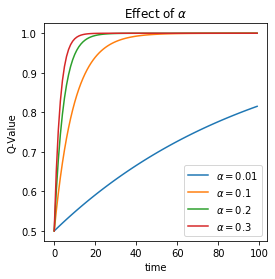

In [7]:
def rw_alpha_effect(param_values, n_iteration=100):

    n_param_values = len(param_values)

    values = np.zeros((n_iteration, n_param_values))

    for i in range(n_param_values):
        agent = RW(
            q_alpha=param_values[i],
            q_beta=None)
        for t in range(n_iteration):

            values[t, i] = agent.q_values[0]
            agent.learn(option=0, success=1)

    return values


# Get data
PARAM_VALUES = (0.01, 0.1, 0.2, 0.3)
Y_VALUES = rw_alpha_effect(PARAM_VALUES)

# Plot
plot.rw_alpha(param_values=PARAM_VALUES, y_values=Y_VALUES)

 * Represent the probability of choice for an option against another depending on the difference of value, for different softmax temperatures ($\beta$)

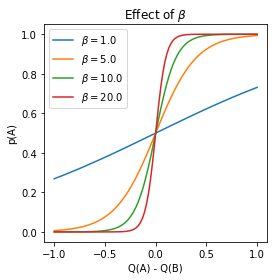

In [8]:
def rw_beta_effect(param_values,
                   min_reward=0,
                   max_reward=1):

    max_diff = max_reward - min_reward
    x_values = np.linspace(-max_diff, max_diff, 100)

    n_x_values = len(x_values)
    n_param_values = len(param_values)

    y_values = np.zeros((len(x_values), n_param_values))

    for i in range(n_param_values):
        for j in range(n_x_values):
            x = x_values[j]
            beta = param_values[i]
            y_values[j, i] = 1 / (1 + np.exp(-beta*x))

    return x_values, y_values


# Get data
PARAM_VALUES = (1.0, 5.0, 10.0, 20.0)
X_VALUES, Y_VALUES = rw_beta_effect(PARAM_VALUES)

# Plot
plot.rw_beta(param_values=PARAM_VALUES,
             x_values=X_VALUES, y_values=Y_VALUES)

### 2.2 Simulate a single agent

**Goal**

- Have a first insight into the expected behavior
- Be sure that your metrics are adapted
- First check about the adequacy between the experimental design and your question(s)

**How to do it?**

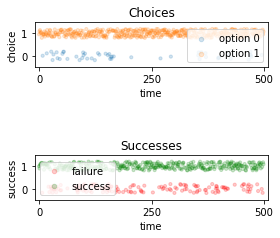

In [9]:
@use_pickle
def run_simulation(seed, agent_model, param=()):

    # Seed the pseudo-random number generator
    np.random.seed(seed)

    # Create the agent
    agent = agent_model(*param)

    # Data containers
    choices = np.zeros(T, dtype=int)
    successes = np.zeros(T, dtype=bool)

    # Simulate the task
    for t in range(T):

        # Determine choice
        choice = agent.choose()

        # Determine success
        p_success = P[choice]
        success = np.random.choice(
            [0, 1],
            p=np.array([1 - p_success, p_success]))

        # Make agent learn
        agent.learn(option=choice, success=success)

        # Backup
        choices[t] = choice
        successes[t] = success

    return choices, successes


# We will experiment with Rescola-Wagner
MODEL_XP = RW

# Get data ----------------------------------------------------
SEED_SINGLE = 0
PARAM_SINGLE = np.array([0.10, 10.00])
CHOICES_SINGLE, SUCCESSES_SINGLE = \
    run_simulation(agent_model=RW, param=PARAM_SINGLE, seed=SEED_SINGLE)

# Plot --------------------------------------------------------
# Begin by the more basic possible
plot.behavior_single_basic(choices=CHOICES_SINGLE,
                           successes=SUCCESSES_SINGLE)

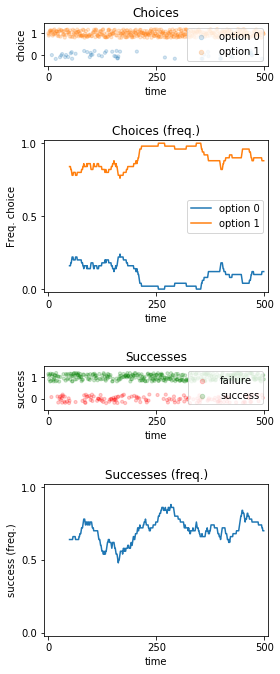

In [10]:
# ...then maybe you can do better
plot.behavior_single_average(choices=CHOICES_SINGLE,
                             successes=SUCCESSES_SINGLE)

### 2.3 Analyse latent variables

**Goal**

- Observe dynamics of your model

**How to do it?**

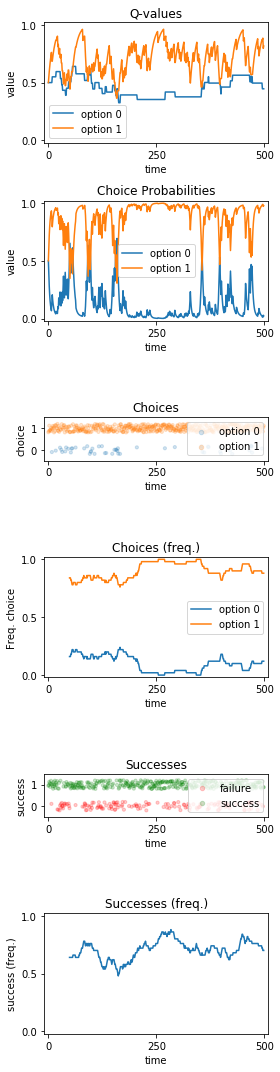

In [11]:
def latent_variables_rw(choices, successes, param):

    """
    Specific to RW
    """

    # Create the agent
    agent = RW(*param)

    # Data containers
    q_values = np.zeros((T, N))
    p_choices = np.zeros((T, N))

    # (Re-)Simulate the task
    for t in range(T):

        # Register values
        q_values[t] = agent.q_values

        # Register probabilities of choices
        p_choices[t] = agent.decision_rule()

        # Make agent learn
        agent.learn(option=choices[t],
                    success=successes[t])

    return q_values, p_choices


# Get the data
Q_VALUES_SINGLE, P_CHOICES_SINGLE = \
    latent_variables_rw(choices=CHOICES_SINGLE,
                        successes=SUCCESSES_SINGLE,
                        param=PARAM_SINGLE)

# Plot
plot.latent_variables_rw_and_behavior_single(q_values=Q_VALUES_SINGLE,
                                             p_choices=P_CHOICES_SINGLE,
                                             choices=CHOICES_SINGLE,
                                             successes=SUCCESSES_SINGLE)

### 2.4 Simulate a population of homogeneous agents

**Goal**

- Evaluate the 'noise' of your behavior by using constant parametrisation
- Get a picture of your expected behavior under the best scenario 
(you find the best model, and subjects share the same best parameters)

**How to do it?**

- Maintain constant the parameters that you are using (except the seed of your pseudo-random number generator)

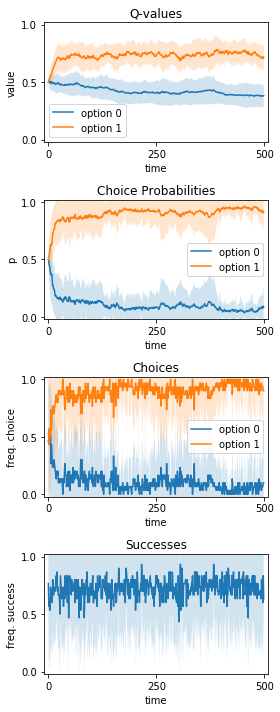

In [12]:
@use_pickle
def run_sim_pop(model, param, n_subjects):

    print(f"Running simulation for {n_subjects} agents...")

    # Data containers
    choices = np.zeros((n_subjects, T), dtype=int)
    successes = np.zeros((n_subjects, T), dtype=bool)

    for i in tqdm(range(n_subjects)):

        # Get choices and successes
        c, s = run_simulation(seed=i,
                              agent_model=model,
                              param=param[i])

        # Backup
        choices[i] = c
        successes[i] = s

    return choices, successes


@use_pickle
def latent_variables_rw_pop(choices, successes, param):

    """
    Specific to RW
    """

    n_subjects = len(choices)

    # Data containers
    q_values = np.zeros((n_subjects, T, N))
    p_choices = np.zeros((n_subjects, T, N))

    for i in range(n_subjects):

        # Get q-values and choice probabilities
        qv, pc = latent_variables_rw(choices=choices[i],
                                     successes=successes[i],
                                     param=param[i])

        # Backup
        q_values[i] = qv
        p_choices[i] = pc

    return q_values, p_choices


# Get the data
PARAM_HOM_POP = [PARAM_SINGLE for _ in range(N_SUBJECTS)]

CHOICES_HOM_POP, SUCCESSES_HOM_POP = \
    run_sim_pop(model=RW, param=PARAM_HOM_POP, n_subjects=N_SUBJECTS)

Q_VALUES_HOM_POP, P_CHOICES_HOM_POP = \
    latent_variables_rw_pop(choices=CHOICES_HOM_POP,
                            successes=SUCCESSES_HOM_POP,
                            param=PARAM_HOM_POP)

# Plot
plot.latent_variables_rw_and_behavior_pop(
    q_values=Q_VALUES_HOM_POP, p_choices=P_CHOICES_HOM_POP,
    choices=CHOICES_HOM_POP, successes=SUCCESSES_HOM_POP)

## 3. Parameter Recovery

<img src="img/optimization.jpeg" width=400>

<img src="img/warning.png" width=20, align="left">&nbsp;**Warning**

You should operate also exploratory simulations (section 2) for ALL the models in competition before proceeding to parameter recovery.

**Goal**

- Be sure that you are able to retrieve the parameters of your model, 
assuming that your model is correct


### 3.1 Define a likelihood function

**Goal**

- Obvious, no?

**How to do it?**

Determine the (log) likelihood of your model:

\begin{equation}
\log p(D \mid M, \theta) = \sum_{d \in D} \log p(d \mid M, \theta)
\end{equation}

In [13]:
def log_likelihood(model, param, choices, successes):

    # Create the agent
    agent = model(*param)

    # Data container
    ll = np.zeros(T)

    # Simulate the task
    for t in range(T):

        # Get choice and success for t
        c, s = choices[t], successes[t]

        # Look at probability of choice
        p_choice = agent.decision_rule()
        p = p_choice[c]

        # Compute log
        ll[t] = np.log(p + np.finfo(np.float).eps)

        # Make agent learn
        agent.learn(option=c, success=s)

    return np.sum(ll)

### 3.2 Choose a way to search for the best parameters

**Goal**

- Identify a method that allow you to identify 'easily' 
the best-fit parameters for each of your models

**How to do it?**

In [14]:
class BanditOptimizer:

    """
    Given a series of choices and successes, and a DM model,
    estimate the best-fit param
    """

    def __init__(self, choices, successes, model):

        self.choices = choices
        self.successes = successes
        self.model = model

        assert hasattr(model, 'fit_bounds'), \
            f"{model.__name__} has not 'fit_bounds' attribute"

        self.t = 0

    def objective(self, param):
        return - log_likelihood(model=self.model,
                                choices=self.choices,
                                successes=self.successes,
                                param=param)

    def run(self):

        if self.model.fit_bounds:
            res = scipy.optimize.minimize(
                fun=self.objective,
                x0=np.array([(b[1] - b[0])/2 for b in self.model.fit_bounds]),
                bounds=self.model.fit_bounds)
            assert res.success

            best_param = res.x
            best_value = res.fun

        else:
            assert self.model == Random
            best_param = ()
            best_value = self.objective(())

        return best_param, best_value

### 3.3 Try with a single agent

**Goal**

- Be sure that in the simplest case (single subject), 
you retrieve close parameters

**How to do it?**

In [15]:
@use_pickle
def get_best_param():

    # Create optimizer
    opt = BanditOptimizer(
        choices=CHOICES_SINGLE,
        successes=SUCCESSES_SINGLE,
        model=RW
    )

    # Run the optimization
    best_param, best_value = opt.run()
    return best_param


# Get the best-fit parameters
BEST_PARAM_SINGLE = get_best_param()
print(f"'True' parameters: {tuple(PARAM_SINGLE)}")
print(f"Best-fit parameters: {tuple(BEST_PARAM_SINGLE)}\n")

'True' parameters: (0.1, 10.0)
Best-fit parameters: (0.09144770878290102, 10.947370614002782)



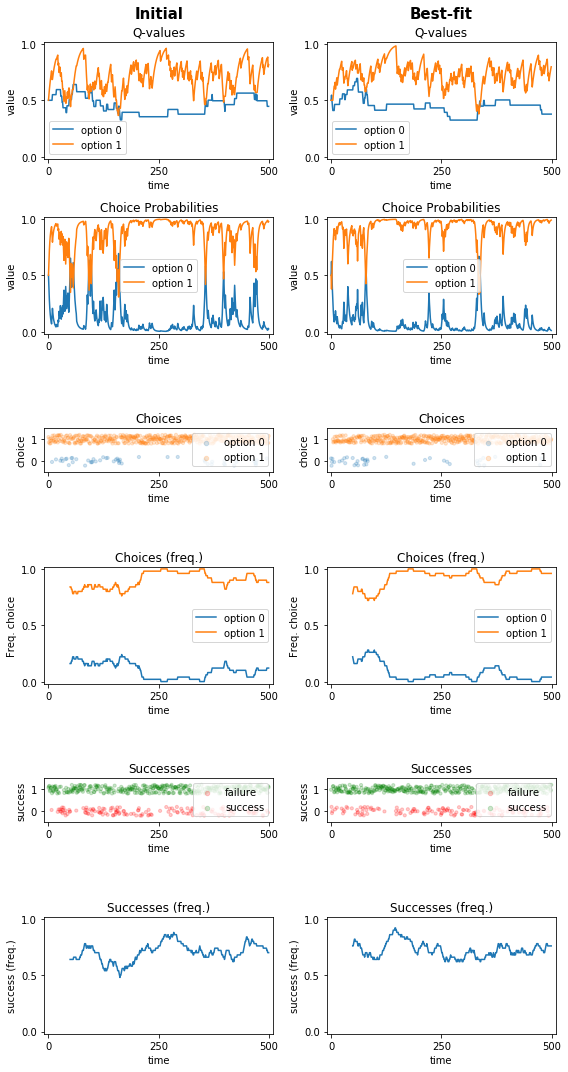

In [16]:
# New simulation with best-fit parameters
CHOICES_SINGLE_BF, SUCCESSES_FIST_BF = \
    run_simulation(seed=SEED_SINGLE + 1, agent_model=RW,
                   param=BEST_PARAM_SINGLE)

# Get the values of the latent variables
Q_VALUES_SINGLE_BF, P_CHOICES_SINGLE_BF = \
    latent_variables_rw(choices=CHOICES_SINGLE_BF,
                        successes=SUCCESSES_FIST_BF,
                        param=BEST_PARAM_SINGLE)

# Plot
plot.comparison_best_fit_rw_single(
    q_values=Q_VALUES_SINGLE, p_choices=P_CHOICES_SINGLE,
    choices=CHOICES_SINGLE, successes=SUCCESSES_SINGLE,
    choices_bf=CHOICES_SINGLE_BF, successes_bf=SUCCESSES_FIST_BF,
    q_values_bf=Q_VALUES_SINGLE_BF, p_choices_bf=P_CHOICES_SINGLE_BF)


### 3.4 Explore the behavior of the likelihood function over the parameter space

**Goal**

- Observe the behavior of your likelihood function over the parameter space
- Notify the local minima 

**How to do it?**

Represent the objective function values over the parameter space (phase diagram)

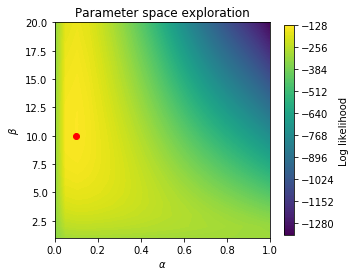

In [17]:
@use_pickle
def parameter_space_exploration(model, choices, successes, grid_size=20):

    """
    Compute likelihood for several combinations of parameters
    (using grid exploration)
    """

    print("Computing data for parameter space exploration...")

    assert len(model.param_labels) == 2, \
        "this function is designed for models that have " \
        "at least and at most 2 parameters"
    assert hasattr(model, 'fit_bounds'), \
        f"{model.__name__} has not 'fit_bounds' attribute"

    n_param = len(model.fit_bounds)

    parameter_values = np.atleast_2d([
                np.linspace(
                    *model.fit_bounds[i],
                    grid_size) for i in range(n_param)
    ])

    # Create a grid for each parameter
    param_grid = np.asarray(list(
            product(*parameter_values)
        ))

    n_sets = len(param_grid)

    # Container for log-likelihood
    ll = np.zeros(n_sets)

    # Loop over each value of the parameter grid for both parameters
    for i in tqdm(range(n_sets)):

        # Select the parameter to use
        param_to_use = param_grid[i]

        # Call the objective function of the optimizer
        ll[i] = log_likelihood(
            choices=choices,
            successes=successes,
            model=model,
            param=param_to_use)

    return parameter_values, ll


# Get data
PARAM_VALUES, LL = parameter_space_exploration(
    model=RW,
    choices=CHOICES_SINGLE,
    successes=SUCCESSES_SINGLE)


# Plot phase diagram
plot.parameter_space_exploration_2d(
    data=LL,
    parameter_values=PARAM_VALUES,
    param_names=RW.param_labels,
    true_params=PARAM_SINGLE,
    title='Parameter space exploration')

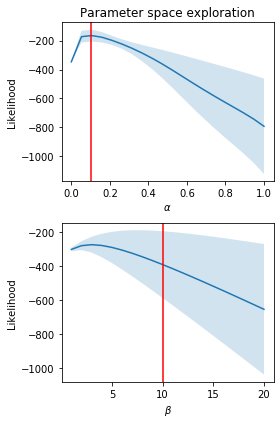

In [18]:
# Separate plot for each parameter
plot.parameter_space_exploration(
    data=LL,
    param_names=RW.param_labels,
    true_params=PARAM_SINGLE,
    parameter_values=PARAM_VALUES,
)

### 3.5 Try with a homogeneous population

**Goal**

- Generalize what you observe with a single subject to a homogeneous population

**How to do it?**

- Maintain constant the parameters that you are using (except the seed of your pseudo-random number generator)

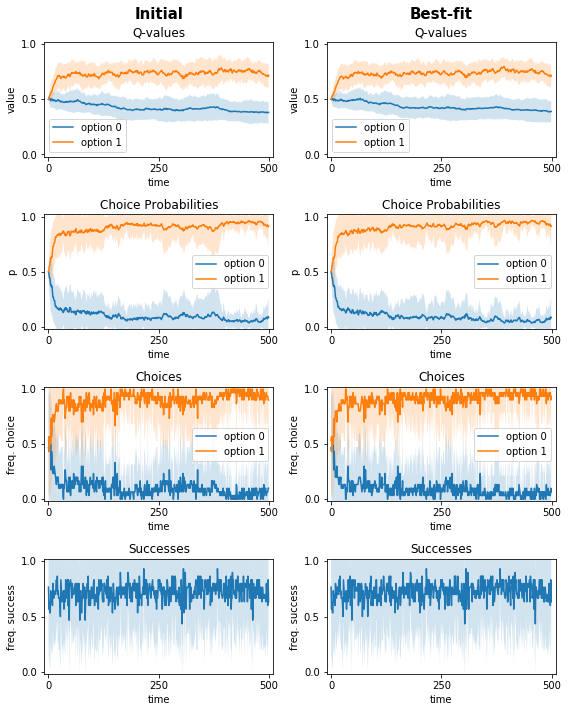

In [19]:
# Define as parameter the best-fit parameter for the single agent
PARAM_HOM_POP_BF = [BEST_PARAM_SINGLE for _ in range(N_SUBJECTS)]

# Get behavior for best-fit
CHOICES_HOM_POP_BF, SUCCESSES_HOM_POP_BF = \
    run_sim_pop(model=RW, param=PARAM_HOM_POP_BF, n_subjects=N_SUBJECTS)

# Get latent variables values
Q_VALUES_HOM_POP_BF, P_CHOICES_HOM_POP_BF = \
    latent_variables_rw_pop(choices=CHOICES_HOM_POP_BF,
                            successes=SUCCESSES_HOM_POP_BF,
                            param=PARAM_HOM_POP_BF)

# Plot
plot.comparison_best_fit_rw_pop(
    choices=CHOICES_HOM_POP, choices_bf=CHOICES_HOM_POP_BF,
    successes=SUCCESSES_HOM_POP, successes_bf=SUCCESSES_HOM_POP_BF,
    q_values=Q_VALUES_HOM_POP, q_values_bf=Q_VALUES_HOM_POP_BF,
    p_choices=P_CHOICES_HOM_POP, p_choices_bf=P_CHOICES_HOM_POP_BF
)

### 3.6 Systematize the process

**Goal**

- Test parameter recovery for a large (enough) set of parameters
- Have a metric of the quality of your parameter recovery (Pearson's r), including statistical assessment of the relevancy

**How to do it?**

Represent the parameters used to simulate against the parameters recovered:

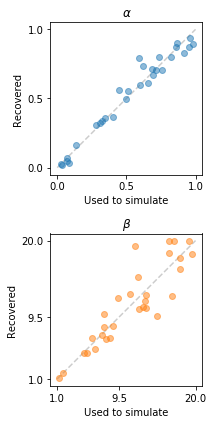

In [20]:
@use_pickle
def data_param_recovery(model, n_sets, seed):

    print("Computing data for parameter recovery...")

    # Seed the random number generator
    np.random.seed(seed)

    # Get the parameters labels
    param_labels = model.param_labels
    n_param = len(param_labels)

    # Data container (2: simulated, retrieved)
    param = np.zeros((n_param, 2, n_sets))

    # Loop over the number of parameter sets
    for set_idx in tqdm(range(n_sets)):

        # Select parameter to simulate...
        param_to_sim = \
            [np.random.uniform(*b)
             for b in model.fit_bounds]

        # Simulate
        choices, successes = run_simulation(seed=set_idx,
                                            agent_model=model,
                                            param=param_to_sim)

        # Create the optimizer and run it
        opt = BanditOptimizer(choices=choices,
                              successes=successes,
                              model=model)
        best_param, best_value = opt.run()

        # Backup
        for i in range(n_param):
            param[i, 0, set_idx] = param_to_sim[i]
            param[i, 1, set_idx] = best_param[i]

    return param


# Get data
P_RCV = data_param_recovery(model=RW, n_sets=30, seed=234)

# Plot
plot.parameter_recovery(data=P_RCV,
                        param_names=RW.param_labels,
                        param_bounds=RW.fit_bounds)

Compute the Pearson's coefficient for each model parameter, and assess the stastistical relevance:

In [21]:
# Stats
stats.correlation_recovery(data=P_RCV, param_names=RW.param_labels)


Statistical analysis for the parameter recovery

[$\alpha$] cor=0.980, p<0.001 *
[$\beta$] cor=0.895, p<0.001 *




## 4. Model Recovery

<img src="img/competition.png" width=400>


<img src="img/warning.png" width=20, align="left">&nbsp;**Warning**


You should operate the process for parameter recovery (section 3) for ALL the models in competition before proceeding to model recovery.

**Goal**

- Ensure that each model, when used for simulating, is selected as the 
best model

### 4.1 Choose a metric

**Goal**

- Choose a metric to compare your models

**How to do it?**

Before all, define your model space. Here, we will compare:
* Random selection
* Win-Stay-Lose-Switch
* Rescola-Wagner
* Rescola-Wagner-Choice-Kernel

In [22]:
MODELS = Random, WSLS, RW, RWCK
MODEL_NAMES = [m.__name__ for m in MODELS]

Then choose a metric to compare your models. Here, we will use the Bayesian Information Criterion (BIC):
\begin{equation}
\text{BIC} = - 2 \log p(D\mid {\widehat {\theta }},M) + k \log(T)
\end{equation}


In [23]:
def bic(ll, k, n_iteration):
    return -2 * ll + k * np.log(n_iteration)

Based on a list of choices and successes, you should be able to compute the metric for each model:

In [24]:
@use_pickle
def optimize_and_compare_single(choices, successes):

    n_models = len(MODELS)
    bic_scores = np.zeros(n_models)
    lls = np.zeros(n_models)
    best_params = []

    for j in range(n_models):

        # Select the model
        model_to_fit = MODELS[j]

        # Create the optimizer and run it
        opt = BanditOptimizer(choices=choices,
                              successes=successes,
                              model=model_to_fit)
        best_param, best_value = opt.run()

        # Get log-likelihood for best param
        ll = -best_value

        # Compute the bit score
        bs = bic(ll, k=len(model_to_fit.fit_bounds), n_iteration=T)

        # Backup
        bic_scores[j] = bs
        lls[j] = ll
        best_params.append(best_param)

    return best_params, lls, bic_scores

### 4.2 Try with a single agent

<img src="img/warning.png" width=20, align="left">&nbsp;**Warning**

You should operate this process for all the models in competition (not only for one, even if you think it is the best one).

**Goal**

- Check that everything is going fine in the most simple case

**How to do it?**

In [25]:
def comparison_single_subject():

    best_params, lls, bic_scores = \
        optimize_and_compare_single(
            choices=CHOICES_SINGLE, successes=SUCCESSES_SINGLE)

    print(f"Model used: {MODEL_XP.__name__}")
    print("-" * 10)

    for i in range(len(MODELS)):
        print(f"BIC {MODELS[i].__name__} = {bic_scores[i]:.3f}")

    print()


# Compute bic scores for evey model for our initial set of data
comparison_single_subject()

Model used: RW
----------
BIC Random = 693.147
BIC WSLS = 598.003
BIC RW = 281.243
BIC RWCK = 294.216



### 4.3 Systematize the approach

**Goal**

* Test that you can generalize what you observed with one single individual

* Have a metric of the quality of your model recovery

**How to do it?**

Draw a confusion matrix:

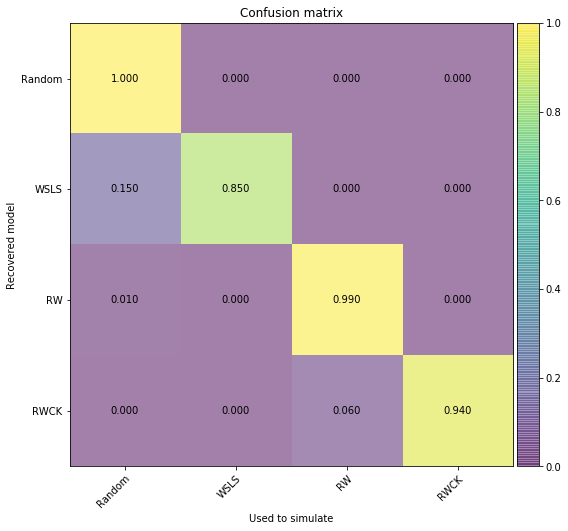

In [26]:
@use_pickle
def data_confusion_matrix(models, n_sets):

    print("Computing data for confusion matrix...")

    # Number of models
    n_models = len(models)

    # Data container
    confusion_matrix = np.zeros((n_models, n_models))

    # Loop over each model
    for i in tqdm(range(n_models)):

        # Select the model
        model_to_sim = models[i]

        for j in range(n_sets):

            # Select parameters to simulate
            param_to_sim = \
                [np.random.uniform(*b)
                 for b in model_to_sim.fit_bounds]

            # Simulate
            choices, successes = \
                run_simulation(
                    seed=j,
                    agent_model=model_to_sim,
                    param=param_to_sim)

            # Compute bic scores
            best_params, lls, bic_scores = \
                optimize_and_compare_single(choices=choices,
                                            successes=successes)

            # Get minimum value for bic (min => best)
            min_ = np.min(bic_scores)

            # Get index of models that get best bic
            idx_min = np.arange(n_models)[bic_scores == min_]

            # Add result in matrix
            confusion_matrix[i, idx_min] += 1/len(idx_min)

    return confusion_matrix


# Data
N_SETS_CONF = 100
SEED_CONF = 123
np.random.seed(SEED_CONF)
CONF_MT = data_confusion_matrix(models=MODELS, n_sets=N_SETS_CONF)

# Plot
plot.confusion_matrix(data=CONF_MT, tick_labels=MODEL_NAMES)

Check the stastical relevancy of your observations:

In [27]:
# Stats
stats.classification(CONF_MT, model_names=MODEL_NAMES)


Statistic analysis for the classification

Random
----------
Precision: 1.000, CI=[1.000, 1.000]
Recall: 0.862, CI=[0.799, 0.925]
F1 score = 0.926

WSLS
----------
Precision: 0.850, CI=[0.780, 0.920]
Recall: 1.000, CI=[1.000, 1.000]
F1 score = 0.919

RW
----------
Precision: 0.990, CI=[0.970, 1.000]
Recall: 0.943, CI=[0.898, 0.987]
F1 score = 0.966

RWCK
----------
Precision: 0.940, CI=[0.893, 0.987]
Recall: 1.000, CI=[1.000, 1.000]
F1 score = 0.969



## 5. Fake experiment

<img src="img/experiment.jpg" width=300>

<img src="img/warning.png" width=20, align="left">&nbsp;**Warning**

You should operate the model recovery process (section 4) for ALL the models in competition (not only for one).

**Goal**

- Have an overview about what the results of your experiment could look like, under the assumption that you get the best model, but that there is small variations in the population in terms of parametrization

- Ensure that the metrics of your behavior is adapted

- Be sure that you can retrieve the model in this context

- Have an idea about the distribution of your metrics regarding model selection (log-likelihood sums, BIC)

- More generally, it is your last resort before the actual experiment (user study) to avoid bad surprises!

**How to do it?**

Generate data with a population of (relatively enough) heterogenous agents:

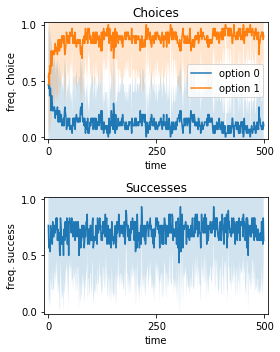

In [28]:
# Get data
SEED_HET_POP = 1234
np.random.seed(SEED_HET_POP)

RW_HET_POP_DIST_PARAM = (0.15, 0.05), (10.0, 0.5)

PARAM_HET_POP = \
    [
        [np.random.normal(*p) for p in RW_HET_POP_DIST_PARAM]
        for _ in range(N_SUBJECTS)
    ]

CHOICES_HET_POP, SUCCESSES_HET_POP = \
    run_sim_pop(model=MODEL_XP, n_subjects=N_SUBJECTS, param=PARAM_HET_POP)

# Plot behavior
plot.behavior_pop(choices=CHOICES_HET_POP, successes=SUCCESSES_HET_POP,
                  n_option=N)

Compare the models: plot the distributions of the likelihoods and your  model comparison metric for each model, as well as the frequence with which each model is the most likely, and the 'best' based on your metric.

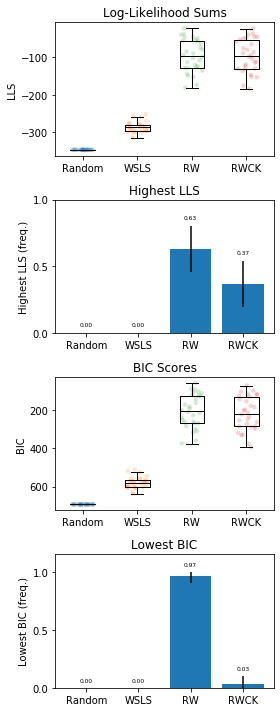

In [29]:
@use_pickle
def optimize_and_compare_pop(choices, successes):

    n_subjects = len(choices)

    # Data containers
    best_parameters = np.zeros(n_subjects, dtype=object)
    lls = np.zeros((n_subjects, len(MODELS)))
    bic_scores = np.zeros((n_subjects, len(MODELS)))

    # Loop over subjects
    for i in tqdm(range(n_subjects)):

        # Optimize and compare
        best_parameters[i], lls[i], bic_scores[i] = \
            optimize_and_compare_single(choices=choices[i],
                                        successes=successes[i])

    # Freq and confidence intervals for the barplot
    lls_freq, lls_err = stats.freq_and_err(lls)
    bic_freq, bic_err = stats.freq_and_err(-bic_scores)

    return lls, lls_freq, lls_err,\
        bic_scores, bic_freq, bic_err, \
        best_parameters


# Get data
LLS_HET, LLS_FREQ_HET, LLS_ERR_HET, \
    BIC_HET, BIC_FQ_HT, BIC_ERR_HET,\
    PARAM_HET_BF = \
    optimize_and_compare_pop(choices=CHOICES_HET_POP,
                             successes=SUCCESSES_HET_POP)

# Plot
plot.model_comparison(
    lls=LLS_HET,
    lls_freq=LLS_FREQ_HET,
    lls_err=LLS_ERR_HET,
    bic_scores=BIC_HET,
    bic_freq=BIC_FQ_HT,
    bic_err=BIC_ERR_HET,
    model_names=MODEL_NAMES
)

Is the model that you used to simulate selected as the best model?

In [30]:
# Look at the best model
BEST_MODEL_IDX = int(np.argmax(BIC_FQ_HT))
BEST_MODEL = MODELS[BEST_MODEL_IDX]

# Assume that it should be the one that you used to simulate
assert MODEL_XP == BEST_MODEL

Plot the distribution of your best-fit parameters:

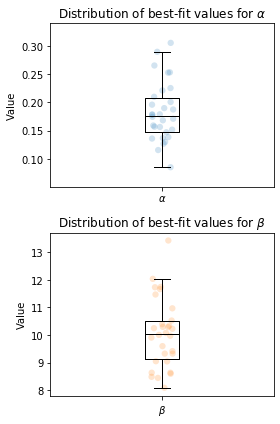

In [31]:
# Retrieve parameters for best model
PARAM_HET_BF_BEST_MODEL = np.asarray(
    [
        PARAM_HET_BF[i][BEST_MODEL_IDX]
        for i in range(N_SUBJECTS)
    ])

# Plot best parameters distribution
plot.distribution_best_parameters(PARAM_HET_BF_BEST_MODEL,
                                  parameter_names=MODEL_XP.param_labels)

Simulate with the best-fit parameters:

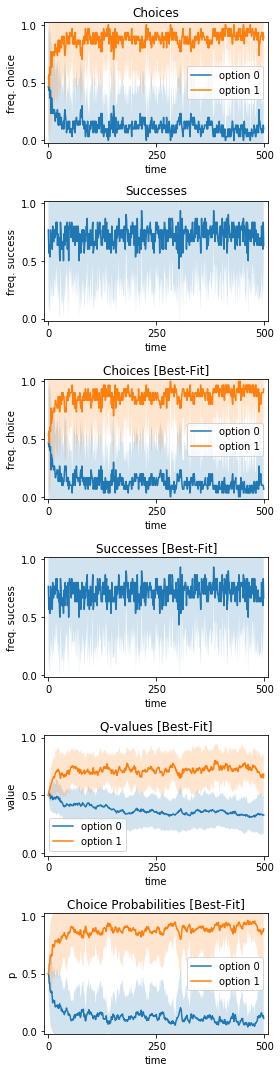

In [32]:
# Get behavior for best-fit
CHOICES_HET_BF, SUCCESSES_HET_BF = \
    run_sim_pop(model=BEST_MODEL, param=PARAM_HET_BF_BEST_MODEL, 
                n_subjects=N_SUBJECTS)

# Get latent variables values
Q_VALUES_HET_BF, P_CHOICES_HET_BF = \
    latent_variables_rw_pop(choices=CHOICES_HET_BF,
                            successes=SUCCESSES_HET_BF,
                            param=PARAM_HET_BF_BEST_MODEL)

plot.post_hoc_sim(
    choices=CHOICES_HET_POP,
    successes=SUCCESSES_HET_POP,
    choices_bf=CHOICES_HET_BF,
    successes_bf=SUCCESSES_HET_BF,
    q_values_bf=Q_VALUES_HET_BF,
    p_choices_bf=P_CHOICES_HET_BF
)

**What do do next?**

Experiment with living agents!